In [11]:
import pandas as pd
import sys

from kornmo import KornmoDataset
from frostdataset import FrostDataset
from visualize import plot
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import kornmo_utils as ku
from visualize import plot_history
from keras.models import load_model

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'KornmoDataset' from 'kornmo' (E:\OneDrive - Universitetet i Agder\kornmo-master-thesis\kornmo\__init__.py)

In [2]:
def filter_by_years(years, data):
    return data[data['year'].isin(years)]

def get_interpolated_data(years, weather_feature):
    data = pd.DataFrame()

    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/nn_interpolated/{weather_feature}/{weather_feature}_interpolated_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    # Drop columns containing 'Unnamed'
    data.drop(columns=[col for col in data.columns if 'Unnamed' in col], inplace=True)

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year', 'longitude', 'latitude', 'elevation']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])

    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

def get_proximity_data(years, weather_feature):
    data = pd.DataFrame()
    print(f"Loading {weather_feature} data...")
    for year in years:
        tmp_df = pd.read_csv(f'../../kornmo-data-files/raw-data/weather-data/by_proximity/{weather_feature}/{weather_feature}_by_proximity_{year}-03-01_to_{year}-10-01.csv')
        tmp_df.drop(columns=['ws_id'], inplace=True)
        tmp_df.insert(0, 'year', year)
        data = pd.concat([data, tmp_df])

    return_data = ku.normalize(data.filter(regex='day_.*'))
    columns_to_add = ['orgnr', 'year']
    for i, col in enumerate(columns_to_add):
        return_data.insert(i, col, data[col])


    print(f"Number of loaded entries: {return_data.shape[0]}")
    return return_data

In [3]:
frost = FrostDataset()
kornmo = KornmoDataset()

years = [2017, 2018, 2019, 2020]

# Grants and deliveries
data = kornmo.get_deliveries().pipe(ku.split_farmers_on_type)
data = filter_by_years(years, data)
data.dropna(inplace=True)

data
#45314 x 15
#60462 x 15

Loading deliveries...
Number of deliveries loaded: 88624


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,areal,bygg,havre,hvete,rug_og_rughvete
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,59.0,1.0,0.0,0.0,0.0
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,215.0,1.0,0.0,0.0,0.0
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,70.0,1.0,0.0,0.0,0.0
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,15.0,0.0,0.0,1.0,0.0
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,106.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60457,2020,999659209,3812,31,64,0,61.0,0.0,0.0,32209,61.0,0.0,0.0,0.0,1.0
60458,2020,999662730,3802,247,1,0,302.0,0.0,0.0,100087,217.0,0.0,1.0,0.0,0.0
60459,2020,999662730,3802,247,1,0,302.0,0.0,0.0,39067,80.0,0.0,0.0,1.0,0.0
60460,2020,999665462,3028,69,1,0,274.0,0.0,56512.0,38686,115.0,0.0,1.0,0.0,0.0


In [4]:
# Temperature and Precipitation
temp_and_precip_data = frost.get_as_aggregated(1)
temp_and_precip_data.tail()

Loading weather data...
Weather data entries loaded: 43157


,year,orgnr,growth_start_day,min_temp0,min_temp1,min_temp2,min_temp3,min_temp4,min_temp5,min_temp6,...,total_rain204,total_rain205,total_rain206,total_rain207,total_rain208,total_rain209,total_rain210,total_rain211,total_rain212,total_rain213
43152,2020,869672092,0.171429,0.383333,0.421667,0.428333,0.465000,0.435000,0.421667,0.361667,...,0.15,0.83,0.17,0.70,0.03,0.18,0.05,-0.0,-0.00,-0.00
43153,2020,995492008,0.171429,0.360000,0.400000,0.430000,0.470000,0.435000,0.426667,0.368333,...,0.23,0.81,0.17,0.72,0.02,0.18,0.06,-0.0,-0.00,-0.00
43154,2020,914335027,0.109524,0.495000,0.518333,0.506667,0.476667,0.435000,0.421667,0.448333,...,-0.00,-0.00,-0.00,0.81,1.22,3.95,0.20,-0.0,0.14,0.19
43155,2020,997795016,0.171429,0.445000,0.515000,0.485000,0.468333,0.406667,0.410000,0.408333,...,-0.00,-0.00,-0.00,1.41,0.55,1.04,0.83,-0.0,-0.00,0.04
43156,2020,968956779,0.380952,0.273333,0.358333,0.428333,0.446667,0.385000,0.453333,0.436667,...,1.10,1.07,0.50,0.36,0.52,0.30,0.01,0.0,0.00,0.00


In [5]:
sunlight_data = get_interpolated_data(years, 'sunlight')
daydegree5_data = get_interpolated_data(years, 'daydegree5').drop(columns=['longitude', 'latitude', 'elevation'])
ground_data = get_proximity_data(years, 'ground')
weather_data = temp_and_precip_data.merge(sunlight_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(daydegree5_data, how='left', on=['orgnr', 'year'])
weather_data = weather_data.merge(ground_data, how='left', on=['orgnr', 'year'])

print(f"Merged {temp_and_precip_data.shape[1]} features of temp and precip data, {sunlight_data.shape[1]} features of sunlight data, {daydegree5_data.shape[1]} features of daydegree data, {ground_data.shape[1]} features of ground data to a total of {weather_data.shape[1]} features")

data = data.merge(weather_data, how='left', on=['year', 'orgnr'])
data = filter_by_years(years, data)

data

Loading sunlight data...
Number of loaded entries: 40616
Loading daydegree5 data...
Number of loaded entries: 40616
Loading ground data...
Number of loaded entries: 40616
Merged 859 features of temp and precip data, 219 features of sunlight data, 216 features of daydegree data, 216 features of ground data to a total of 1504 features


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,day_204,day_205,day_206,day_207,day_208,day_209,day_210,day_211,day_212,day_213
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.285714,0.00,0.125,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,...,0.142857,0.25,0.125,0.111111,0.142857,0.111111,0.285714,0.111111,0.000000,0.111111
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,...,0.142857,0.25,0.125,0.111111,0.142857,0.111111,0.285714,0.111111,0.000000,0.111111
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,...,0.142857,0.00,0.125,0.111111,0.285714,0.111111,0.142857,0.111111,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64187,2020,999659209,3812,31,64,0,61.0,0.0,0.0,32209,...,0.000000,0.00,0.125,0.222222,0.142857,0.222222,0.142857,0.000000,0.111111,0.111111
64188,2020,999662730,3802,247,1,0,302.0,0.0,0.0,100087,...,0.000000,0.00,0.000,0.222222,0.285714,0.222222,0.285714,0.111111,0.222222,0.222222
64189,2020,999662730,3802,247,1,0,302.0,0.0,0.0,39067,...,0.000000,0.00,0.000,0.222222,0.285714,0.222222,0.285714,0.111111,0.222222,0.222222
64190,2020,999665462,3028,69,1,0,274.0,0.0,56512.0,38686,...,0.000000,0.00,0.125,0.111111,0.142857,0.222222,0.142857,0.111111,0.111111,0.111111


In [6]:
# Legacy grants
historical_data = ku.get_historical_production(kornmo, data.year.unique(), 4)
data = data.merge(historical_data, on=['orgnr', 'year'])
data = filter_by_years(years, data)
data
# 47191 x 1541
# 62309 x 1541

Loading historical grants data...
Historical data loaded for years 2013 to 2020.


,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,levert,...,havre_sum_1,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3
0,2017,811555762,1653,24,2,0,59.0,0.0,0.0,17067,...,0.0000,0.0,2.0620,0.0000,0.0000,0.0,2.2445,0.0000,0.0000,0.0
1,2017,811580082,1124,25,5,0,744.0,0.0,361336.0,81204,...,0.0000,0.0,6.4999,0.0000,0.0000,0.0,11.7227,0.0000,0.0000,0.0
2,2017,811675792,709,2023,12,0,105.0,0.0,0.0,10902,...,0.6015,0.0,0.0000,1.4844,0.2770,0.0,0.0000,2.2717,0.4869,0.0
3,2017,811675792,709,2023,12,0,105.0,0.0,0.0,2335,...,0.6015,0.0,0.0000,1.4844,0.2770,0.0,0.0000,2.2717,0.4869,0.0
4,2017,811935662,125,207,1,0,106.0,0.0,0.0,33166,...,0.0000,0.0,0.0000,0.0000,0.0000,0.0,1.0643,2.5620,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61937,2020,999659209,3812,31,64,0,61.0,0.0,0.0,32209,...,0.0000,0.0,0.0000,0.0000,1.5396,0.0,1.3426,0.0000,0.0000,0.0
61938,2020,999662730,3802,247,1,0,302.0,0.0,0.0,100087,...,8.2873,0.0,0.0000,1.8919,5.8078,0.0,0.0000,4.4841,8.6888,0.0
61939,2020,999662730,3802,247,1,0,302.0,0.0,0.0,39067,...,8.2873,0.0,0.0000,1.8919,5.8078,0.0,0.0000,4.4841,8.6888,0.0
61940,2020,999665462,3028,69,1,0,274.0,0.0,56512.0,38686,...,2.1122,0.0,0.0000,0.0000,0.6108,0.0,0.0000,0.0000,2.1835,0.0


In [7]:
#'elevation' in data.columns

In [8]:
data.dropna(inplace=True)

data['y'] = data['levert'] / data['areal']
data.drop('levert', axis=1, inplace=True)

data['y'] = ku.normalize(data['y'], 0, 1000)
data['areal'] = ku.normalize(data['areal'])
data['fulldyrket'] = ku.normalize(data['fulldyrket'])
data['overflatedyrket'] = ku.normalize(data['overflatedyrket'])
data['tilskudd_dyr'] = ku.normalize(data['tilskudd_dyr'])
data['growth_start_day'] = ku.normalize(data['growth_start_day'])
data['elevation'] = ku.normalize(data['elevation'])
data['latitude'] = ku.normalize(data['latitude'])
data['longitude'] = ku.normalize(data['longitude'])

y_column = ['y']
remove_from_training = ['orgnr', 'kommunenr', 'gaardsnummer', 'bruksnummer', 'festenummer', 'year'] + y_column

data
# 41383 x 1541

,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,areal,...,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3,y
0,2017,811555762,1653,24,2,0,0.007241,0.0,0.000000,0.017475,...,0.0,2.0620,0.0000,0.0000,0.0,2.2445,0.0000,0.0000,0.0,0.289271
1,2017,811580082,1124,25,5,0,0.110575,0.0,0.335581,0.064477,...,0.0,6.4999,0.0000,0.0000,0.0,11.7227,0.0000,0.0000,0.0,0.377693
2,2017,811675792,709,2023,12,0,0.014180,0.0,0.000000,0.020789,...,0.0,0.0000,1.4844,0.2770,0.0,0.0000,2.2717,0.4869,0.0,0.155743
3,2017,811675792,709,2023,12,0,0.014180,0.0,0.000000,0.004218,...,0.0,0.0000,1.4844,0.2770,0.0,0.0000,2.2717,0.4869,0.0,0.155667
4,2017,811935662,125,207,1,0,0.014331,0.0,0.000000,0.031636,...,0.0,0.0000,0.0000,0.0000,0.0,1.0643,2.5620,0.0000,0.0,0.312887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61937,2020,999659209,3812,31,64,0,0.007543,0.0,0.000000,0.018078,...,0.0,0.0000,0.0000,1.5396,0.0,1.3426,0.0000,0.0000,0.0,0.528016
61938,2020,999662730,3802,247,1,0,0.043898,0.0,0.000000,0.065080,...,0.0,0.0000,1.8919,5.8078,0.0,0.0000,4.4841,8.6888,0.0,0.461230
61939,2020,999662730,3802,247,1,0,0.043898,0.0,0.000000,0.023802,...,0.0,0.0000,1.8919,5.8078,0.0,0.0000,4.4841,8.6888,0.0,0.488337
61940,2020,999665462,3028,69,1,0,0.039674,0.0,0.052484,0.034348,...,0.0,0.0000,0.0000,0.6108,0.0,0.0000,0.0000,2.1835,0.0,0.336400


In [9]:
data.tail()

,year,orgnr,kommunenr,gaardsnummer,bruksnummer,festenummer,fulldyrket,overflatedyrket,tilskudd_dyr,areal,...,rug_og_rughvete_sum_1,bygg_sum_2,hvete_sum_2,havre_sum_2,rug_og_rughvete_sum_2,bygg_sum_3,hvete_sum_3,havre_sum_3,rug_og_rughvete_sum_3,y
61937,2020,999659209,3812,31,64,0,0.007543,0.0,0.000000,0.018078,...,0.0,0.0000,0.0000,1.5396,0.0,1.3426,0.0000,0.0000,0.0,0.528016
61938,2020,999662730,3802,247,1,0,0.043898,0.0,0.000000,0.065080,...,0.0,0.0000,1.8919,5.8078,0.0,0.0000,4.4841,8.6888,0.0,0.461230
61939,2020,999662730,3802,247,1,0,0.043898,0.0,0.000000,0.023802,...,0.0,0.0000,1.8919,5.8078,0.0,0.0000,4.4841,8.6888,0.0,0.488337
61940,2020,999665462,3028,69,1,0,0.039674,0.0,0.052484,0.034348,...,0.0,0.0000,0.0000,0.6108,0.0,0.0000,0.0000,2.1835,0.0,0.336400
61941,2020,999666248,3030,252,10,0,0.022477,0.0,0.000000,0.047906,...,0.0,3.8498,0.0000,0.0000,0.0,9.5683,0.0000,0.0000,0.0,0.629144


In [10]:
train, val = train_test_split(shuffle(data), test_size=0.2)
val, test = train_test_split(val, test_size=0.2)

train_x = train.drop(remove_from_training, axis=1).to_numpy()
train_y = train[y_column].to_numpy()

val_x = val.drop(remove_from_training, axis=1).to_numpy()
val_y = val[y_column].to_numpy()

print(f'Training dataset x: {train_x.shape}')
print(f'Training dataset y: {train_y.shape}')
print(f'Validation dataset x: {val_x.shape}')
print(f'Validation dataset y : {val_y.shape}')


Training dataset x: (44076, 1526)
Training dataset y: (44076, 1)
Validation dataset x: (8816, 1526)
Validation dataset y : (8816, 1)


Epoch 1/1000
87/87 [==============================] - 2s 7ms/step - loss: 0.3305 - val_loss: 0.1269
Epoch 2/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1989 - val_loss: 0.1111
Epoch 3/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1595 - val_loss: 0.1061
Epoch 4/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1404 - val_loss: 0.1063
Epoch 5/1000
87/87 [==============================] - 0s 5ms/step - loss: 0.1297 - val_loss: 0.1053
Epoch 6/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1240 - val_loss: 0.1051
Epoch 7/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1189 - val_loss: 0.1037
Epoch 8/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1161 - val_loss: 0.1036
Epoch 9/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1135 - val_loss: 0.1027
Epoch 10/1000
87/87 [==============================] - 0s 4ms/step - loss: 0.1120 - val_loss: 0.1016

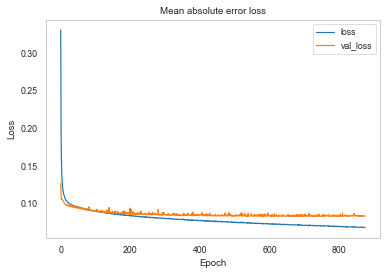

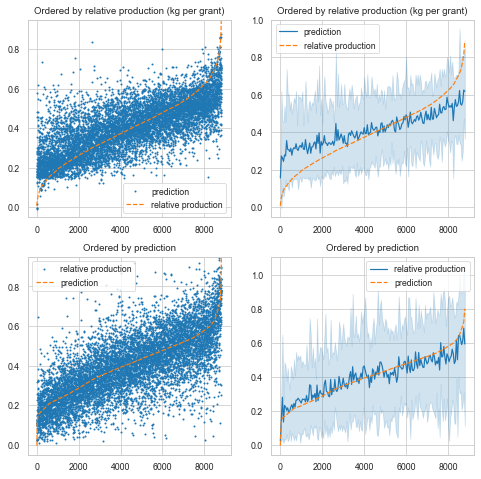

Saving model and history object


In [11]:
from kornmo.dense_model import train_simple_dense
logs_name = 'more_data_and_features'

model, history = train_simple_dense(train_x, train_y, val_x, val_y)
plot_history(history.history, save_file=f"logs/dnn_loss_{logs_name}.svg")
plot(model, val_x, val_y)


print("Saving model and history object")

pd.DataFrame(history.history).to_csv(f'logs/history_{logs_name}.csv')
model.save(f"logs/dnn_model_{logs_name}.keras")

Denormalized MAE: 82.75492528797614


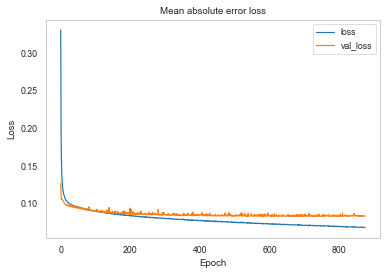

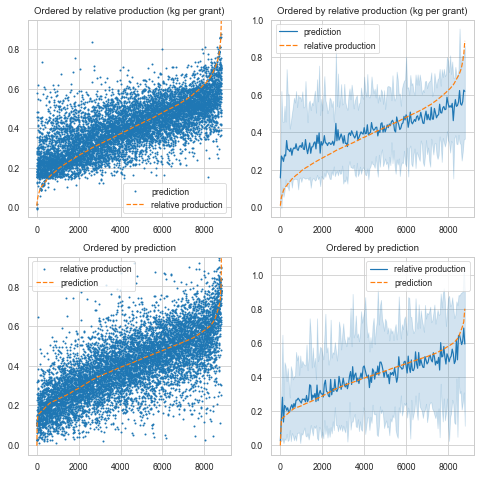

In [12]:
history = pd.read_csv(f'logs/history_{logs_name}.csv')
plot_history(history, save_file=f"logs/dnn_loss_{logs_name}.svg")

model = load_model(f"logs/dnn_model_{logs_name}.keras")
plot(model, val_x, val_y)